In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

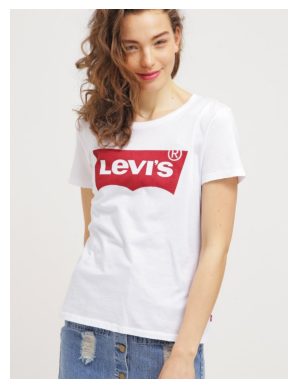

In [2]:
# Đường dẫn đến hình ảnh
image_path = "../datasets/viton-hd/train/image/00000_00.jpg"

# Đọc hình ảnh
image = Image.open(image_path)

# Hiển thị hình ảnh
plt.imshow(image)
plt.axis("off")  # Tắt hiển thị trục
plt.show()

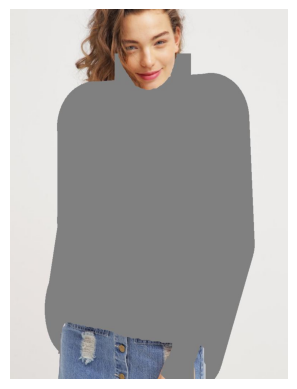

In [3]:
# Đường dẫn đến hình ảnh
image_path = "../datasets/viton-hd/train/agnostic-v3.2/00000_00.jpg"

# Đọc hình ảnh
image = Image.open(image_path)

# Hiển thị hình ảnh
plt.imshow(image)
plt.axis("off")  # Tắt hiển thị trục
plt.show()

In [4]:
a = np.array(image)
b = np.where(np.all(a == [128, 128, 128], axis=-1), 1, 0)
# b = a[300:400, 300:500, ]
# plt.imshow(b)
b

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

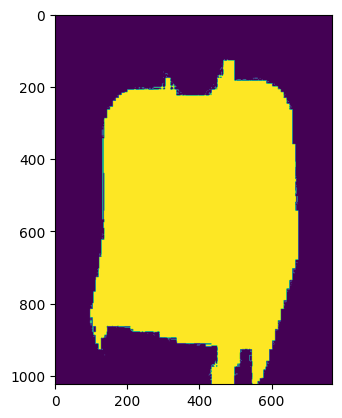

In [5]:
plt.imshow(b)

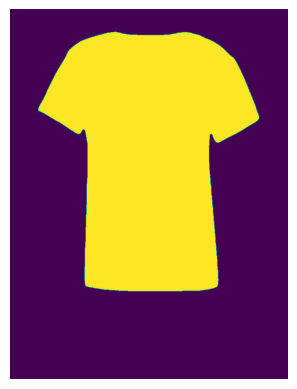

In [6]:
# Đường dẫn đến hình ảnh
image_path = "../datasets/viton-hd/train/cloth-mask/00000_00.jpg"

# Đọc hình ảnh
image = Image.open(image_path)

# Hiển thị hình ảnh
plt.imshow(image)
plt.axis("off")  # Tắt hiển thị trục
plt.show()

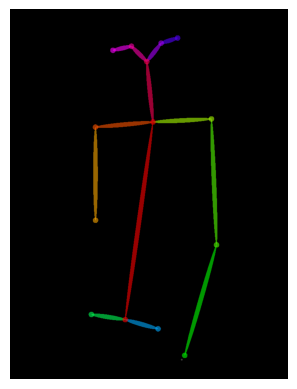

In [7]:
# Đường dẫn đến hình ảnh
image_path = "../datasets/viton-hd/train/openpose_img/00000_00_rendered.png"

# Đọc hình ảnh
image = Image.open(image_path)

# Hiển thị hình ảnh
plt.imshow(image)
plt.axis("off")  # Tắt hiển thị trục
plt.show()

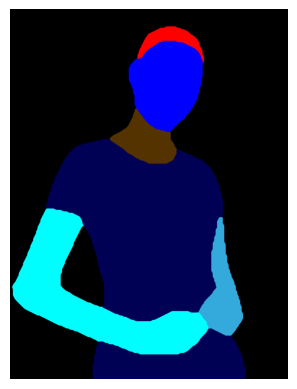

In [26]:
# Đường dẫn đến hình ảnh
image_path = "../datasets/viton-hd/train/image-parse-v3/01789_00.png"

# Đọc hình ảnh
image = Image.open(image_path).convert("RGB")

# Hiển thị hình ảnh
plt.imshow(image)
plt.axis("off")  # Tắt hiển thị trục
plt.show()

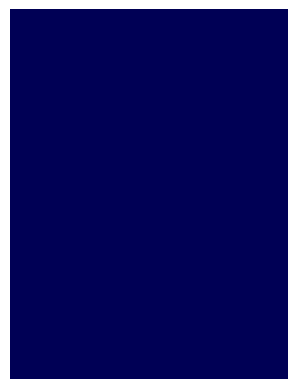

In [30]:
a = np.array(image)[500:700, 250:400, :]
plt.imshow(a)
plt.axis("off")  # Tắt hiển thị trục
plt.show()

In [31]:
a

array([[[ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85],
        ...,
        [ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85]],

       [[ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85],
        ...,
        [ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85]],

       [[ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85],
        ...,
        [ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85]],

       ...,

       [[ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85],
        ...,
        [ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85]],

       [[ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85],
        ...,
        [ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85]],

       [[ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85],
        ...,
        [ 0,  0, 85],
        [ 0,  0, 85],
        [ 0,  0, 85]]], dtype=uint8)

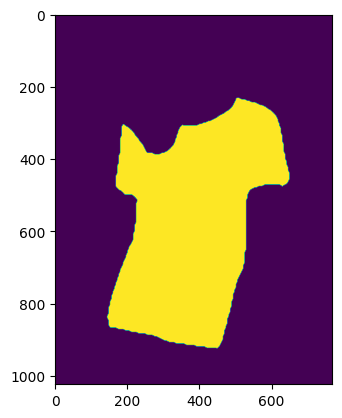

In [9]:
a = np.array(image)
b = np.where(a == 5, 1, 0)
plt.imshow(b)

In [10]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = (1024, 768)  # the generated image resolution
    train_batch_size = 4
    eval_batch_size = 4  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-6
    lr_warmup_steps = 10
    save_image_epochs = 5
    save_model_epochs = 1
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "baseline"  # the model name locally and on the HF Hub
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # device = "cpu"
    num_steps=2000
    num_samples=500

#     push_to_hub = True  # whether to upload the saved model to the HF Hub
#     hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
#     hub_private_repo = False
#     overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

class VTONHDDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, feature_extractor=None):
        """
        :param annotations_file: Đường dẫn đến file chứa các cặp ảnh
        :param img_dir: Thư mục chứa ảnh
        :param transform: Các phép biến đổi cho ảnh
        :param feature_extractor: Mô hình trích xuất đặc trưng cho trang phục
        """
        with open(annotations_file, 'r') as f:
            self.image_pairs = [line.strip().split() for line in f.readlines()][:config.num_samples]
        self.img_dir = img_dir
        self.transform = transform
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        person_path, clothing_path = self.image_pairs[idx]
        clothing_image = Image.open(f"{self.img_dir}/cloth/{clothing_path}").convert("RGB")
        agnostic_image = Image.open(f"{self.img_dir}/agnostic-v3.2/{person_path}").convert("RGB")
        person_image = Image.open(f"{self.img_dir}/image/{person_path}").convert("RGB")

        if self.transform:
            agnostic_image = self.transform(agnostic_image)
            clothing_image = self.transform(clothing_image)
            person_image = self.transform(person_image)

        # Trích xuất đặc trưng cho trang phục
        with torch.no_grad():
            clothing_features = self.feature_extractor(clothing_image.unsqueeze(0)).squeeze(0)

        return agnostic_image, clothing_image, clothing_features, person_image

# Biến đổi cho ảnh và trích xuất đặc trưng trang phục
transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Sử dụng ResNet tiền huấn luyện để trích xuất đặc trưng cho trang phục
resnet = models.resnet50(pretrained=True)
feature_extractor = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Loại bỏ lớp cuối cùng

# Tạo DataLoader
DATASET_DIR = "../datasets/viton-hd"
dataset = VTONHDDataset(annotations_file=os.path.join(".", 'VITONHD_train_paired.txt'), img_dir=os.path.join(DATASET_DIR, 'train'), 
                        transform=transform, feature_extractor=feature_extractor)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

/home/jupyter/hungbd/viton_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter/hungbd/viton_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Kích thước của batch:
Hình ảnh người: torch.Size([4, 3, 1024, 768])
Đặc trưng trang phục: torch.Size([4, 2048, 1, 1])
Đặc trưng trang phục: torch.Size([4, 3, 1024, 768])


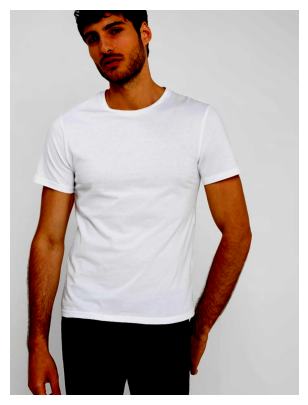

In [9]:
# prompt: get a sample from dataloader

# Lấy một mẫu từ DataLoader
dataiter = iter(dataloader)
person_images, clothing_images, clothing_features, person_clothing_images = next(dataiter)

# In ra kích thước của batch
print("Kích thước của batch:")
print("Hình ảnh người:", person_images.shape)
print("Đặc trưng trang phục:", clothing_features.shape)
print("Đặc trưng trang phục:", person_clothing_images.shape)

# Hiển thị một vài hình ảnh người
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.subplot(1, 1, i+1)
    plt.imshow(person_clothing_images[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()

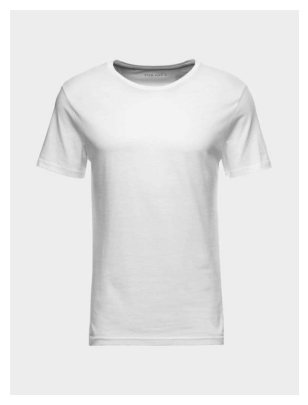

In [10]:
# Hiển thị một vài hình ảnh người
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.subplot(1, 1, i+1)
    plt.imshow(clothing_images[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [11]:
from accelerate import Accelerator

/home/jupyter/hungbd/viton_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from diffusers import AutoencoderKL
from diffusers import DDPMScheduler, UNet2DConditionModel, UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

unet = UNet2DModel(
    in_channels=12,
    out_channels=4,
    # Sử dụng block_out_channels để chỉ định số lượng kênh trong mỗi block
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",  # A downsampling layer with spatial resolution reduction
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # A downsampling layer with spatial resolution reduction and attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # An upsampling layer with spatial resolution increase
        "AttnUpBlock2D",  # An upsampling layer with spatial resolution increase and attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

unet = unet.from_pretrained("./baselinev2/unet_stabilityai")

# unet = nn.DataParallel(unet)

unet = unet.to(config.device)

vae = vae.to(config.device)

for param in vae.parameters():
    param.requires_grad = False

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

In [13]:
def total_trainable_params(model: torch.nn.Module):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

In [14]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

# Hàm mất mát
def diffusion_loss(prediction, target):
    return torch.nn.functional.mse_loss(prediction, target)

def train_loop(config, unet, vae, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    
#     if accelerator.is_main_process:
#         if config.output_dir is not None:
#             os.makedirs(config.output_dir, exist_ok=True)
#         if config.push_to_hub:
#             repo_id = create_repo(
#                 repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
#             ).repo_id
#         accelerator.init_trackers("train_example")
        
    device = config.device

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    unet, vae, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, vae, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    
    print(f"VAE trainable params:", total_trainable_params(vae))
    print(f"Unet trainable params:", total_trainable_params(unet))

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            agnostic_image, clothing_image, clothing_feature, person_image = batch
            # Sample noise to add to the images
            bs = person_image.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=device,
                dtype=torch.int64
            )

            person_image = vae.encode(person_image).latent_dist.sample() 
            person_image *= vae.config.scaling_factor
            agnostic_image = vae.encode(agnostic_image).latent_dist.sample() 
            agnostic_image *= vae.config.scaling_factor
            clothing_image = vae.encode(clothing_image).latent_dist.sample()
            clothing_image *= vae.config.scaling_factor
            
            noise = torch.randn(person_image.shape, device=device)
            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_image = noise_scheduler.add_noise(person_image, noise, timesteps)
            
            inputs = torch.cat([noisy_image, agnostic_image, clothing_image], dim=1).to(device)
            
            print(f"inputs shape:", inputs.shape)
                
            with accelerator.accumulate(unet):
                # Predict the noise residual
                noise_pred = unet(inputs, timesteps).sample
                # noisy_dim = noisy_image.shape[-1]
                # noise_pred = noise_pred[..., :noisy_dim]
                loss = diffusion_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            # print(f"step: {global_step}, loss: {loss.detach().item()}")
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
            
            if global_step == config.num_steps:
                break
        
        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            unet.module.save_pretrained(os.path.join(config.output_dir, "unetv2"))
    
        if global_step == config.num_steps:
            break

In [15]:
# from accelerate import notebook_launcher
# import torch
# import torch.multiprocessing as mp

# args = (config, unet, vae, noise_scheduler, optimizer, dataloader, lr_scheduler)

# train_loop(*args)

In [31]:
# accelerator = Accelerator(
#     mixed_precision=config.mixed_precision,
#     gradient_accumulation_steps=config.gradient_accumulation_steps,
#     log_with="tensorboard",
#     project_dir=os.path.join(config.output_dir, "logs"),
# )

prediction = []
for agnostic_image, clothing_image, clothing_feature, person_image in dataloader:
    agnostic_image = agnostic_image
    clothing_image = clothing_image
    clothing_feature = clothing_feature
    person_image = person_image
    device = config.device
    agnostic_image = agnostic_image.to(device)
    clothing_image = clothing_image.to(device)
    person_image = person_image.to(device)
    clothing_feature = clothing_feature.to(device)
    num_inference_steps = 200
    noise_scheduler.set_timesteps(num_inference_steps)
    guidance_scale = 7.5
    with torch.no_grad():
        person_image = vae.encode(person_image).latent_dist.sample() 
        person_image *= vae.config.scaling_factor
        agnostic_image = vae.encode(agnostic_image).latent_dist.sample() 
        agnostic_image *= vae.config.scaling_factor
        clothing_image = vae.encode(clothing_image).latent_dist.sample()
        clothing_image *= vae.config.scaling_factor
        print("done vae")
        
        timesteps = torch.full((person_image.shape[0], ), num_inference_steps).to(device)

        noise = torch.randn(person_image.shape, device=device)
        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_image = noise_scheduler.add_noise(person_image, noise, timesteps)
        
        noisy_image = noisy_image*noise_scheduler.init_noise_sigma

        # inputs = torch.cat([noisy_image, agnostic_image, clothing_image], dim=1).to(device)
        
        print("ready to loop")
        
        for i in range(len(person_image)):
            _noisy_image = noisy_image[i:i+1]
            _agnostic_image = agnostic_image[i:i+1]
            _clothing_image = clothing_image[i:i+1]
            # _inputs = inputs[i:i+1]
            for t in tqdm(noise_scheduler.timesteps):
                _noisy_image = noise_scheduler.scale_model_input(_noisy_image, timestep=t)
                _inputs = torch.cat([_noisy_image, _agnostic_image, _clothing_image], dim=1).to(device)
                _inputs = _inputs.repeat(2, 1, 1, 1)
                noisy_residual = unet(_inputs, t).sample
                noise_pred_uncond, noise_pred_text = noisy_residual.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                _noisy_image = noise_scheduler.step(noise_pred, t, _noisy_image).prev_sample
                # _inputs = previous_noisy_sample
            
            # image_dim = person_image.shape[-1]
            # prediction.append(_inputs[..., :image_dim])
            prediction.append(_noisy_image)
        break

done vae
ready to loop


  0%|          | 1/200 [00:00<00:31,  6.38it/s]

tensor(0., device='cuda:0')


  2%|▏         | 3/200 [00:00<00:15, 12.61it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


  2%|▎         | 5/200 [00:00<00:13, 14.84it/s]

tensor(0., device='cuda:0')


  4%|▎         | 7/200 [00:00<00:12, 15.94it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


  4%|▍         | 9/200 [00:00<00:11, 16.53it/s]

tensor(0., device='cuda:0')


  6%|▌         | 11/200 [00:00<00:11, 16.98it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


  6%|▋         | 13/200 [00:00<00:10, 17.25it/s]

tensor(0., device='cuda:0')


  8%|▊         | 15/200 [00:00<00:10, 17.52it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


  8%|▊         | 17/200 [00:01<00:10, 17.48it/s]

tensor(0., device='cuda:0')


 10%|▉         | 19/200 [00:01<00:10, 17.38it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 10%|█         | 21/200 [00:01<00:10, 17.51it/s]

tensor(0., device='cuda:0')


 12%|█▏        | 23/200 [00:01<00:10, 17.52it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 12%|█▎        | 25/200 [00:01<00:09, 17.67it/s]

tensor(0., device='cuda:0')


 14%|█▎        | 27/200 [00:01<00:09, 17.60it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 14%|█▍        | 29/200 [00:01<00:09, 17.65it/s]

tensor(0., device='cuda:0')


 16%|█▌        | 31/200 [00:01<00:09, 17.72it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 16%|█▋        | 33/200 [00:01<00:09, 17.64it/s]

tensor(0., device='cuda:0')


 18%|█▊        | 35/200 [00:02<00:09, 17.66it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 18%|█▊        | 37/200 [00:02<00:09, 17.66it/s]

tensor(0., device='cuda:0')


 20%|█▉        | 39/200 [00:02<00:09, 17.74it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 20%|██        | 41/200 [00:02<00:08, 17.73it/s]

tensor(0., device='cuda:0')


 22%|██▏       | 43/200 [00:02<00:08, 17.71it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 22%|██▎       | 45/200 [00:02<00:08, 17.75it/s]

tensor(0., device='cuda:0')


 24%|██▎       | 47/200 [00:02<00:08, 17.72it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 24%|██▍       | 49/200 [00:02<00:08, 17.78it/s]

tensor(0., device='cuda:0')


 26%|██▌       | 51/200 [00:02<00:08, 17.72it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 26%|██▋       | 53/200 [00:03<00:08, 17.74it/s]

tensor(0., device='cuda:0')


 28%|██▊       | 55/200 [00:03<00:08, 17.64it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 28%|██▊       | 57/200 [00:03<00:08, 17.55it/s]

tensor(0., device='cuda:0')


 30%|██▉       | 59/200 [00:03<00:07, 17.64it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 30%|███       | 61/200 [00:03<00:07, 17.62it/s]

tensor(0., device='cuda:0')


 32%|███▏      | 63/200 [00:03<00:07, 17.63it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 32%|███▎      | 65/200 [00:03<00:07, 17.63it/s]

tensor(0., device='cuda:0')


 34%|███▎      | 67/200 [00:03<00:07, 17.20it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


KeyboardInterrupt: 

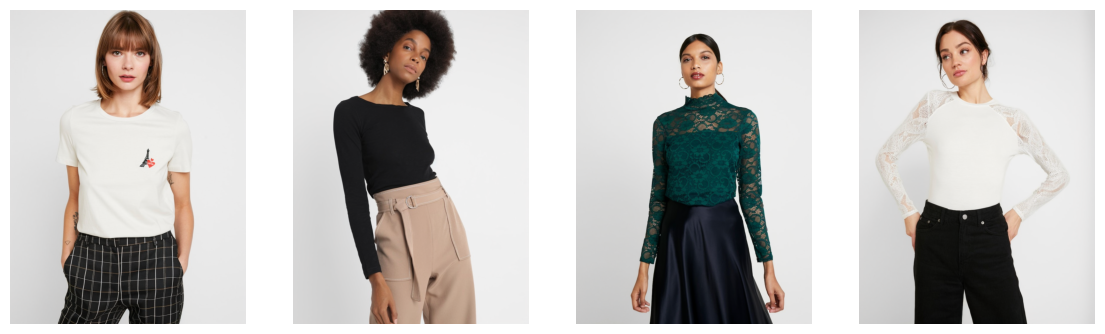

In [28]:
# prompt: show an image with 64x64 size

plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    p = person_image[i].unsqueeze(0).to(config.device)
    p = 1 / 0.18215 * p
    with torch.no_grad():
        p = vae.decode(p).sample
    p = (p / 2 + 0.5).clamp(0, 1)
    plt.imshow(p.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')
plt.show()

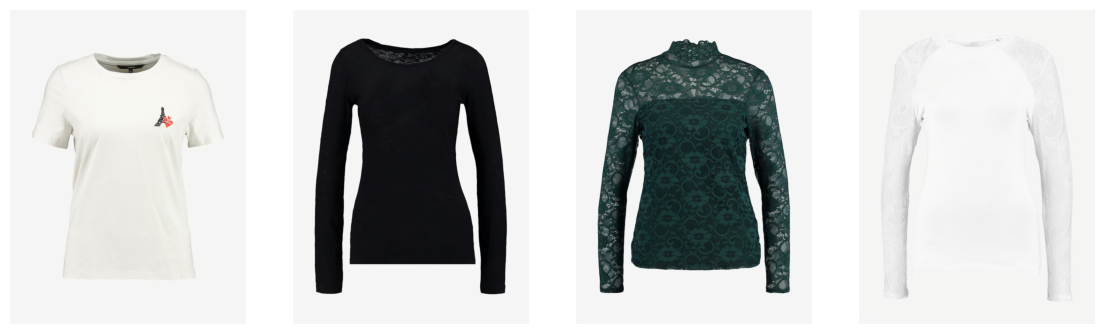

In [29]:
# prompt: show an image with 64x64 size
plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    p = clothing_image[i].unsqueeze(0).to(config.device)
    p = 1 / 0.18215 * p
    with torch.no_grad():
        p = vae.decode(p).sample
    p = (p / 2 + 0.5).clamp(0, 1)
    plt.imshow(p.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')
plt.show()

torch.Size([1, 3, 1024, 768])
torch.Size([1, 3, 1024, 768])
torch.Size([1, 3, 1024, 768])
torch.Size([1, 3, 1024, 768])


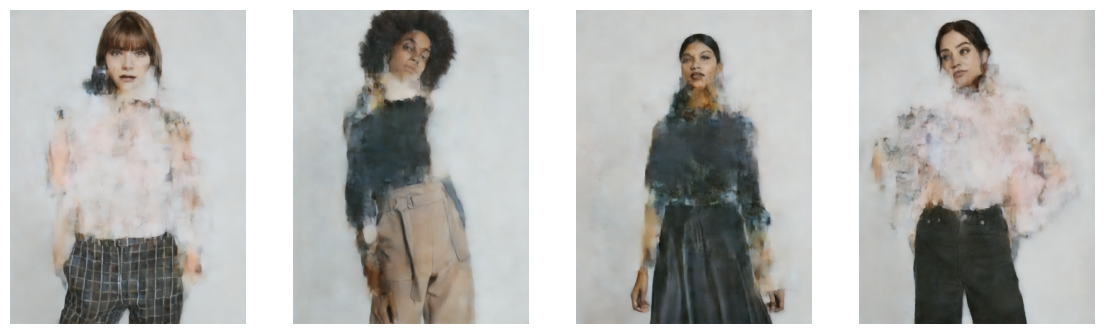

In [30]:
# prompt: show an image with 64x64 size
plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    p = prediction[i]
    p = 1 / 0.18215 * p
    with torch.no_grad():
        p = vae.decode(p).sample
    print(p.shape)
    p = (p / 2 + 0.5).clamp(0, 1)
    plt.imshow(p.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')
plt.show()

In [ ]:
# Tạo DataLoader
DATASET_DIR = "../datasets/viton-hd"
dataset = VTONHDDataset(annotations_file=os.path.join(DATASET_DIR, 'train_pairs.txt'), img_dir=os.path.join(DATASET_DIR, 'train'), 
                        transform=transform, feature_extractor=feature_extractor)
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
# accelerator = Accelerator(
#     mixed_precision=config.mixed_precision,
#     gradient_accumulation_steps=config.gradient_accumulation_steps,
#     log_with="tensorboard",
#     project_dir=os.path.join(config.output_dir, "logs"),
# )

prediction = []
for agnostic_image, clothing_image, clothing_feature, person_image in dataloader:
    agnostic_image = agnostic_image[:1]
    clothing_image = clothing_image[:1]
    clothing_feature = clothing_feature[:1]
    person_image = person_image[:1]
    device = config.device
    agnostic_image = agnostic_image.to(device)
    clothing_image = clothing_image.to(device)
    person_image = person_image.to(device)
    clothing_feature = clothing_feature.to(device)
    num_inference_steps = 50
    noise_scheduler.set_timesteps(num_inference_steps)
    guidance_scale = 7.5
    with torch.no_grad():
        person_image = vae.encode(person_image).latent_dist.sample() 
        person_image *= vae.config.scaling_factor
        agnostic_image = vae.encode(agnostic_image).latent_dist.sample() 
        agnostic_image *= vae.config.scaling_factor
        clothing_image = vae.encode(clothing_image).latent_dist.sample()
        clothing_image *= vae.config.scaling_factor
        print("done vae")
        
        timesteps = torch.full((person_image.shape[0], ), num_inference_steps).to(device)

        noise = torch.randn(person_image.shape, device=device)
        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_image = noise_scheduler.add_noise(person_image, noise, timesteps)
        
        noisy_image = noisy_image*noise_scheduler.init_noise_sigma

        # inputs = torch.cat([noisy_image, agnostic_image, clothing_image], dim=1).to(device)
        
        print("ready to loop")
        
        for i in range(len(person_image)):
            _noisy_image = noisy_image[i:i+1]
            _agnostic_image = agnostic_image[i:i+1]
            _clothing_image = clothing_image[i:i+1]
            # _inputs = inputs[i:i+1]
            for t in tqdm(noise_scheduler.timesteps):
                _noisy_image = noise_scheduler.scale_model_input(_noisy_image, timestep=t)
                _inputs = torch.cat([_noisy_image, _agnostic_image, _clothing_image], dim=1).to(device)
                _inputs = _inputs.repeat(2, 1, 1, 1)
                noisy_residual = unet(_inputs, t).sample
                noise_pred_uncond, noise_pred_text = noisy_residual.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                _noisy_image = noise_scheduler.step(noise_pred, t, _noisy_image).prev_sample
                # _inputs = previous_noisy_sample
            
            # image_dim = person_image.shape[-1]
            # prediction.append(_inputs[..., :image_dim])
            prediction.append(_noisy_image)
            break
        break

In [ ]:
# prompt: show an image with 64x64 size
p = person_image[0].unsqueeze(0).to(config.device)
p = 1 / 0.18215 * p
with torch.no_grad():
    p = vae.decode(p).sample
p = (p / 2 + 0.5).clamp(0, 1)
plt.imshow(p.squeeze(0).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

In [ ]:
# prompt: show an image with 64x64 size
p = clothing_image[0].unsqueeze(0).to(config.device)
p = 1 / 0.18215 * p
with torch.no_grad():
    p = vae.decode(p).sample
p = (p / 2 + 0.5).clamp(0, 1)
plt.imshow(p.squeeze(0).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

In [ ]:
# prompt: show an image with 64x64 size
p = prediction[0]
p = 1 / 0.18215 * p
with torch.no_grad():
    p = vae.decode(p).sample
print(p.shape)
p = (p / 2 + 0.5).clamp(0, 1)
plt.imshow(p.squeeze(0).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()